# Walk-through
Training - Compress - Visualization

## Clone Repo
I directly mounted a Google Drive. Clone the repo as needed

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/Othercomputers/My MacBook Pro/Projects/SR-INR

Mounted at /content/drive
/content/drive/Othercomputers/My MacBook Pro/Projects/SR-INR


## Training

Using image 21 for example, we train a wide but shallow INR (layer size of 150 with 2 layers). Refer to the COIN paper/repo for more information

In [ ]:
!python train.py --num_iters 100000 --layer_size 150 --num_layers 2 --image_id 21

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
Fitting SIREN to Kodak Image21...
Model size: 94.2kB
Full precision bpp: 1.92
100%|██████████████| 100000/100000 [20:49<00:00, 80.04it/s, best_psnr=25.6, loss=0.00275, psnr=25.6]
Best training psnr: 25.64


## Apply post-training sparsification/quantization algorithms
Make sure that the image id, layer size and number of layers are consistent as the training input

### Quantization
Only supports half precision quantization right now.


In [ ]:
!python compress.py --image_id 21 --compression_type Quantization --layer_size 150 --num_layers 2 --quant_level half

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/content/drive/Othercomputers/My MacBook Pro/Projects/SR-INR/modules/model_compression.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless 

### Magnitude Pruning
prune_ratio of 0.5 is 50% pruning.

In [ ]:
!python compress.py --image_id 21 --compression_type Mag_Pruning --layer_size 150 --num_layers 2  --prune_ratio 0.5 --refine_iter 5000

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/content/drive/Othercomputers/My MacBook Pro/Projects/SR-INR/modules/model_compression.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless 

### SuRP

In [ ]:
!python compress.py --image_id 21 --compression_type SuRP --layer_size 150 --num_layers 2 --surp_iter 100000 --image_iter 1000

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/content/drive/Othercomputers/My MacBook Pro/Projects/SR-INR/modules/model_compression.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless 

## Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio
from IPython.display import Image
image_id = 21
base_path = f'results/image_{image_id}'
base_SuRP_path = base_path + '/SuRP'


### Image Display
Original image - Full INR Reconstruction - Quantized (Half Precision) Reconstruction

Pruned Reconstruction - SuRP Reconstruction (Iter 50000) - SuRP Reconstruction (Iter 100000)

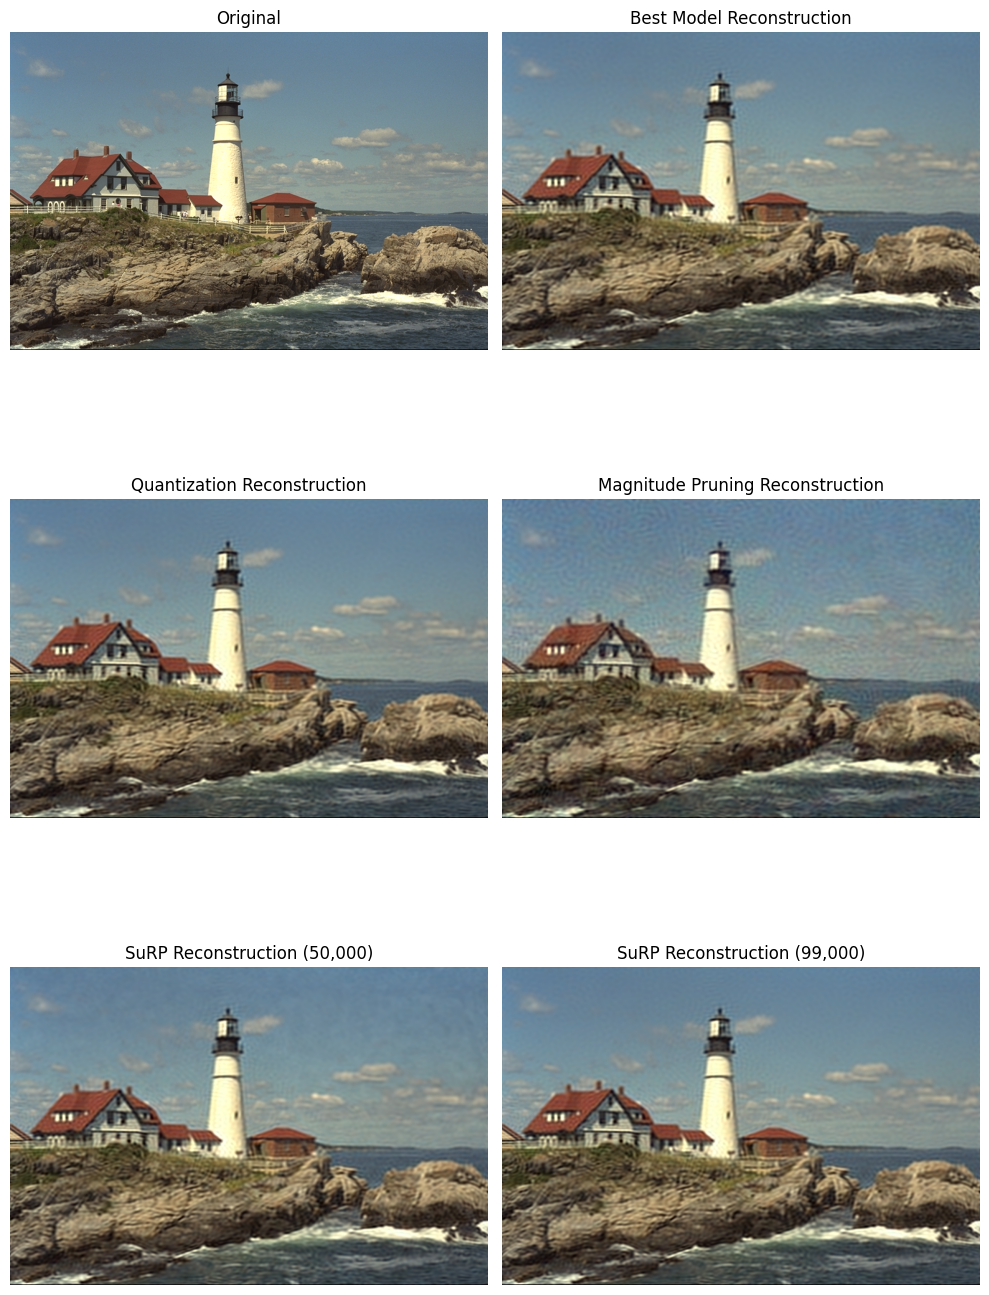

In [ ]:
original = imageio.imread(f'kodak-dataset/kodim{image_id}.png')
full = imageio.imread(base_path + f'/Best_Model_Reconstruction_{image_id}.png')
quant = imageio.imread(base_path + f'/Quantization_reconstruction_{image_id}.png')
pruned = imageio.imread(base_path + f'/Mag_Pruning_reconstruction_{image_id}.png')
SuRP_50000 = imageio.imread(base_SuRP_path + f'/SuRP_reconstruction_{image_id}_50000.png')
SuRP_99000 = imageio.imread(base_SuRP_path + f'/SuRP_reconstruction_{image_id}_99000.png')

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

axes[0, 0].imshow(original)
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(full)
axes[0, 1].set_title('Best Model Reconstruction')
axes[0, 1].axis('off')

axes[1, 0].imshow(quant)
axes[1, 0].set_title('Quantization Reconstruction')
axes[1, 0].axis('off')

axes[1, 1].imshow(pruned)
axes[1, 1].set_title('Magnitude Pruning Reconstruction')
axes[1, 1].axis('off')

axes[2, 0].imshow(SuRP_50000)
axes[2, 0].set_title('SuRP Reconstruction (50,000)')
axes[2, 0].axis('off')

axes[2, 1].imshow(SuRP_99000)
axes[2, 1].set_title('SuRP Reconstruction (99,000)')
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

### Empirical Weight Distribution and Iter vs. Sparsity/PSNR Plot

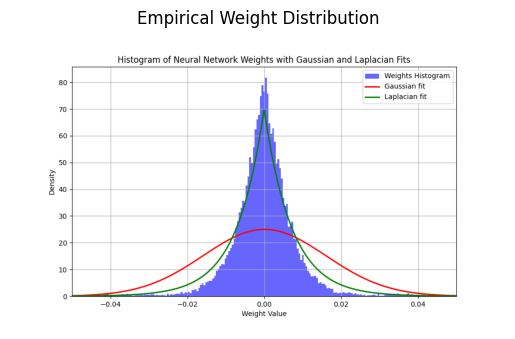

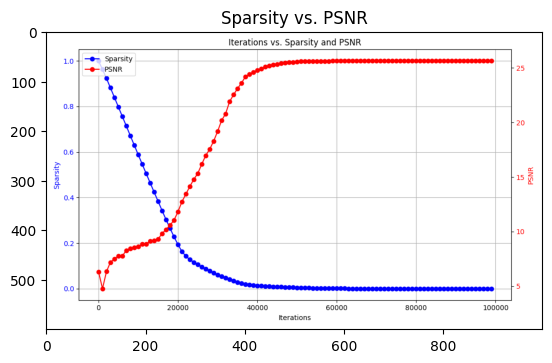

In [26]:
weight_dist = imageio.imread(base_SuRP_path + '/weight_plot_histogram.png')
psnr_plot = imageio.imread(base_SuRP_path + '/sparsity_psnr_plot.png')

plt.imshow(weight_dist)
plt.title('Empirical Weight Distribution')
plt.axis('off')
plt.show()

plt.imshow(psnr_plot)
plt.title('Sparsity vs. PSNR')
plt.show()

### SuRP Animation

In [ ]:
# Convert to a looped gif
!sudo apt-get install imagemagick
!convert '/content/drive/Othercomputers/My MacBook Pro/Projects/SR-INR/results/image_21/SuRP/result_animation.gif' -loop 0 '/content/drive/Othercomputers/My MacBook Pro/Projects/SR-INR/results/image_21/SuRP/result_animation_looped.gif'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
imagemagick is already the newest version (8:6.9.11.60+dfsg-1.3ubuntu0.22.04.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
# If not displayed, please directly open result_animation_looped.gif
Image(base_SuRP_path + '/result_animation_looped.gif')

Output hidden; open in https://colab.research.google.com to view.